### Extracting embeddings

Importing packages.

In [39]:
import os
import librosa
import torch
from tqdm import tqdm
import numpy as np
from transformers import WhisperFeatureExtractor, WhisperModel


Mounting the data from drive

In [ ]:
directory_path = '/content/drive/MyDrive/enhancing_speaker_recognition_evaluation/data'

print(len(os.listdir(directory_path)))

In [ ]:
directory_path = os.path.expanduser("/home/rag/experimental_trial/data/all_speakers")

print(len(os.listdir(directory_path)))

Defining device.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Now we're extracting the vector representations of the audio files in different stages of the encoder.

In [ ]:
import os
import numpy as np
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from tqdm import tqdm
import librosa

# Initialize the processor and model for wav2vec 2.0
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-large-960h", output_hidden_states=True)
model.to(device)

def check_directories_exist(directory, layer_indices):
    """Prüft, ob die benötigten Verzeichnisse für jede Schicht bereits existieren."""
    all_exist = True
    for index in layer_indices:
        layer_dir = os.path.join(directory, f"layer_{index}")
        if not os.path.exists(layer_dir):
            all_exist = False
            break
    return all_exist

def load_audio_files(directory, layer_indices=[-1]):
    """Lädt alle MP3-Dateien im angegebenen Verzeichnis und extrahiert die Repräsentationen aus den spezifizierten Schichten."""
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith(".mp3"):
            file_path = os.path.join(directory, filename)
            audio, sr = librosa.load(file_path, sr=16000)
            inputs = processor(audio, sampling_rate=sr, return_tensors="pt")
            input_values = inputs["input_values"].to(device)
            
            with torch.no_grad():
                outputs = model(input_values)
                for index in layer_indices:
                    hidden_states = outputs.hidden_states[index]
                    # creating sub directory for each layer in speaker directory
                    layer_dir = os.path.join(directory, f"layer_{index}")
                    os.makedirs(layer_dir, exist_ok=True)
                    save_path = os.path.join(layer_dir, f"{os.path.splitext(filename)[0]}_layer_{index}.npy")
                    np.save(save_path, hidden_states.cpu().numpy())

def process_audio_directory(base_directory, layer_indices=range(25)):
    """Verarbeitet Audio-Dateien in den angegebenen Verzeichnissen, falls die Ziellayer-Verzeichnisse noch nicht existieren."""
    for d in os.listdir(base_directory):
        dir_path = os.path.join(base_directory, d)
        if os.path.isdir(dir_path) and not check_directories_exist(dir_path, layer_indices):
            load_audio_files(dir_path, layer_indices)

directory_path = os.path.expanduser("/home/rag/experimental_trial/data/all_speakers_w2vec_28.05")

process_audio_directory(directory_path)


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 50/50 [00:04<00:00, 10.68it/s]


# finetuning wavtovec

first we prepare the daataset for finetuning

In [6]:
import os
import random
import shutil
from tqdm import tqdm

# Define the path to the dataset
base_path = '/home/rag/experimental_trial/data/finetuning_dataset_large'

# Number of files for each subfolder
train_count = 80
test_count = 10
validate_count = 10

# Iterate over each folder in the base directory
for folder in tqdm(os.listdir(base_path), desc="Processing folders"):
    folder_path = os.path.join(base_path, folder)
    
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        clips = os.listdir(folder_path)
        
        # Ensure there are exactly 30 clips
        if len(clips) == 100:
            # Shuffle clips randomly
            random.shuffle(clips)
            
            # Define subfolders and number of clips for each
            subsets = {
                'train': train_count,
                'test': test_count,
                'validate': validate_count
            }
            
            # Create subfolders and move files
            for subset, count in subsets.items():
                subset_path = os.path.join(folder_path, subset)
                os.makedirs(subset_path, exist_ok=True)
                
                # Display a progress bar for moving clips to each subfolder
                for clip in tqdm(clips[:count], desc=f"Moving files to {subset}", leave=False):
                    shutil.move(os.path.join(folder_path, clip), subset_path)
                
                # Remove the moved clips from the list
                clips = clips[count:]



Processing folders: 100%|██████████| 165/165 [00:01<00:00, 107.13it/s]


now we rename all the speakers to in order to decrease length of filepath

In [ ]:
import os
import csv

# Define the path to the directory containing the subfolders
base_directory = '/home/rag/experimental_trial/data/finetuning_dataset_large'

# Path for the CSV file to record the name changes
csv_file_path = os.path.join(base_directory, 'folder_rename_log.csv')

def rename_subfolders():
    # Get all items in the directory
    items = os.listdir(base_directory)
    counter = 1  # Initialize a counter for the folder names

    # Create or overwrite the CSV file to store old and new names
    with open(csv_file_path, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(['old_name', 'new_name'])  # Write the header

        # Iterate over each item in the directory
        for item in items:
            item_path = os.path.join(base_directory, item)
            # Check if the item is a directory
            if os.path.isdir(item_path):
                new_name = f'speaker_{counter}'
                new_path = os.path.join(base_directory, new_name)
                os.rename(item_path, new_path)  # Rename the directory
                writer.writerow([item, new_name])  # Log the change in the CSV
                counter += 1

if __name__ == '__main__':
    rename_subfolders()


check integrity of audio files

In [5]:
import os
from moviepy.editor import VideoFileClip

def check_mp4_integrity(filepath):
    try:
        # Attempt to load the video file using moviepy
        video = VideoFileClip(filepath)
        # Attempt to get the duration to ensure the file is readable
        duration = video.duration
        video.reader.close()
        video.audio.reader.close_proc()
        return True
    except Exception as e:
        return False

def check_directory(base_dir):
    corrupted_files = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.mp4'):
                filepath = os.path.join(root, file)
                if not check_mp4_integrity(filepath):
                    corrupted_files.append(filepath)
    return corrupted_files

def main():
    base_dir = '/home/rag/experimental_trial/data/finetuning_dataset_large'
    corrupted_files = check_directory(base_dir)
    
    if corrupted_files:
        print("Corrupted files found:")
        for file in corrupted_files:
            print(file)
    else:
        print("All files are intact.")

if __name__ == "__main__":
    main()


All files are intact.


now generate csv files with labels

In [7]:
import os
import pandas as pd

def create_csv_from_dataset(root_dir, output_csv):
    data = []

    print(f"Scanning root directory: {root_dir}")
    if not os.path.exists(root_dir):
        print(f"Root directory does not exist: {root_dir}")
        return

    for speaker in os.listdir(root_dir):
        speaker_dir = os.path.join(root_dir, speaker)
        if os.path.isdir(speaker_dir):
            print(f"Processing speaker directory: {speaker_dir}")
            for subset in ['train', 'test', 'validate']:
                subset_dir = os.path.join(speaker_dir, subset)
                if os.path.isdir(subset_dir):
                    print(f"Processing subset directory: {subset_dir}")
                    files_in_subset = os.listdir(subset_dir)
                    if not files_in_subset:
                        print(f"No files found in directory: {subset_dir}")
                    for filename in files_in_subset:
                        file_path = os.path.join(subset_dir, filename)
                        print(f"Found file: {file_path} with extension {os.path.splitext(filename)[1]}")
                        if filename.endswith('.mp3'):
                            data.append({
                                'filename': filename,
                                'path': file_path,
                                'label': speaker,
                                'subset': subset
                            })
                            print(f"Added file: {file_path}")
                        else:
                            print(f"Skipped file with unsupported extension: {file_path}")

    if data:
        df = pd.DataFrame(data)
        df.to_csv(output_csv, index=False)
        print(f"CSV file created at: {output_csv}")
    else:
        print("No data to write to CSV.")

# Specify the root directory of your dataset and the output CSV file path
root_dir = '/home/rag/experimental_trial/data/finetuning_dataset_large'
output_csv = 'dataset_large.csv'

create_csv_from_dataset(root_dir, output_csv)


Scanning root directory: /home/rag/experimental_trial/data/finetuning_dataset_large
Processing speaker directory: /home/rag/experimental_trial/data/finetuning_dataset_large/speaker_6
Processing subset directory: /home/rag/experimental_trial/data/finetuning_dataset_large/speaker_6/train
Found file: /home/rag/experimental_trial/data/finetuning_dataset_large/speaker_6/train/8dec8422ff907ed644c5af9c3f985dc9bc1a6d3e4530d6d6a8e235ed6e925df3ed4953c758fc83fc43686c8b25c88961eed6e938476a53810c1f605fc8364a5b.mp3 with extension .mp3
Added file: /home/rag/experimental_trial/data/finetuning_dataset_large/speaker_6/train/8dec8422ff907ed644c5af9c3f985dc9bc1a6d3e4530d6d6a8e235ed6e925df3ed4953c758fc83fc43686c8b25c88961eed6e938476a53810c1f605fc8364a5b.mp3
Found file: /home/rag/experimental_trial/data/finetuning_dataset_large/speaker_6/train/87ca082c21113b4a0a6929e51905d4656de77b9a5f5e109c4dd0611aee245f7043a806b6937edbc0017e0e51be91e3ff42aac1726c841dc681a7703d7105d365.mp3 with extension .mp3
Added file: /

jetzt mit cuda und häufigerer eval von training und vali los

In [1]:
import os
import sys
import torch
import librosa
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
import math
from datasets import load_metric
from datetime import datetime

# Initialize the processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

# Define a custom dataset class using pandas
class LocalAudioDataset(Dataset):
    def __init__(self, csv_file, processor, subset):
        self.processor = processor
        self.data = pd.read_csv(csv_file)
        self.data = self.data[self.data['subset'] == subset]
        self.speaker_ids = {label: idx for idx, label in enumerate(self.data['label'].unique())}
        self.data['label'] = self.data['label'].map(self.speaker_ids)
        
        # Print speaker information for debugging
        print(f"Loaded {len(self.speaker_ids)} speakers: {self.speaker_ids}")
        print(f"Total files in {subset}: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = self.data.iloc[idx]['path']
        label = self.data.iloc[idx]['label']
        
        try:
            audio, sr = librosa.load(file_path, sr=16000)  # Load and resample to 16000 Hz
            audio = librosa.to_mono(audio)  # Convert to mono
            audio = self._pad_or_truncate(audio, max_length=16000)
            input_values = self.processor(audio, sampling_rate=16000, return_tensors="pt").input_values.squeeze(0)
            return {"input_values": input_values, "labels": label}
        except Exception as e:
            print(f"Error loading {file_path}: {e}", file=sys.stderr)
            return self.__getitem__((idx + 1) % len(self))

    def _pad_or_truncate(self, audio, max_length):
        if len(audio) < max_length:
            # Pad
            pad_size = max_length - len(audio)
            audio = np.pad(audio, (0, pad_size), 'constant', constant_values=(0, 0))
        else:
            # Truncate
            audio = audio[:max_length]
        return audio

# Paths to dataset CSV file
csv_file = 'dataset_large.csv'
train_dataset = LocalAudioDataset(csv_file, processor, 'train')
validate_dataset = LocalAudioDataset(csv_file, processor, 'validate')
test_dataset = LocalAudioDataset(csv_file, processor, 'test')

# Define the model with the number of labels equal to the unique number of speakers
num_speakers = len(train_dataset.speaker_ids)
print(f"Number of unique speakers: {num_speakers}")

# Print labels for debugging
print(f"Labels in train dataset: {train_dataset.data['label'].tolist()}")
print(f"Labels in test dataset: {test_dataset.data['label'].tolist()}")

model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-large-960h", num_labels=num_speakers)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

# Add validation to check label values
def validate_labels(dataset):
    for item in dataset:
        label = item['labels']
        if label >= num_speakers or label < 0:
            print(f"Invalid label {label} for item: {item}")
            raise ValueError(f"Invalid label {label} found in dataset.")
    print("All labels are valid.")

validate_labels(train_dataset)
validate_labels(validate_dataset)
validate_labels(test_dataset)

# Calculate steps per epoch
batch_size = 8
steps_per_epoch = math.ceil(len(train_dataset) / batch_size)
logging_steps = steps_per_epoch // 5
eval_steps = steps_per_epoch // 5

# Load accuracy metric
accuracy_metric = load_metric("accuracy")

# Define the compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# Initialize log file and directory with a timestamp
log_dir = "/home/rag/experimental_trial/results/training_logs"
os.makedirs(log_dir, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_file = os.path.join(log_dir, f"training_log_{timestamp}.csv")
with open(log_file, "w") as f:
    f.write("Timestamp,Step,Training Loss,Validation Loss,Accuracy\n")

# Custom callback to log metrics
class SaveMetricsCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            with open(log_file, "a") as f:
                timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                step = state.global_step
                training_loss = logs.get("loss", "")
                validation_loss = logs.get("eval_loss", "")
                accuracy = logs.get("eval_accuracy", "")
                f.write(f"{timestamp},{step},{training_loss},{validation_loss},{accuracy}\n")

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    group_by_length=True,
    per_device_train_batch_size=batch_size,
    evaluation_strategy="steps",
    num_train_epochs=45,
    save_steps=logging_steps,
    eval_steps=eval_steps,
    logging_steps=logging_steps,
    learning_rate=5e-6,  # Reduce the learning rate
    save_total_limit=2,
    no_cuda=False  # Ensure that CUDA is used if available
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validate_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics,  # Pass the compute_metrics function to the trainer
    callbacks=[SaveMetricsCallback()]  # Add the custom callback
)

# Start training
trainer.train()

# Evaluate the model on the test set
metrics = trainer.evaluate(test_dataset)

print(f"Test set evaluation metrics: {metrics}")
print("Training and evaluation completed successfully!")


Loaded 111 speakers: {'speaker_6': 0, 'speaker_156': 1, 'speaker_22': 2, 'speaker_19': 3, 'speaker_91': 4, 'speaker_27': 5, 'speaker_94': 6, 'speaker_34': 7, 'speaker_97': 8, 'speaker_100': 9, 'speaker_36': 10, 'speaker_128': 11, 'speaker_134': 12, 'speaker_68': 13, 'speaker_9': 14, 'speaker_17': 15, 'speaker_73': 16, 'speaker_42': 17, 'speaker_52': 18, 'speaker_151': 19, 'speaker_150': 20, 'speaker_141': 21, 'speaker_82': 22, 'speaker_130': 23, 'speaker_75': 24, 'speaker_58': 25, 'speaker_74': 26, 'speaker_104': 27, 'speaker_47': 28, 'speaker_135': 29, 'speaker_71': 30, 'speaker_83': 31, 'speaker_116': 32, 'speaker_99': 33, 'speaker_108': 34, 'speaker_31': 35, 'speaker_106': 36, 'speaker_28': 37, 'speaker_65': 38, 'speaker_48': 39, 'speaker_49': 40, 'speaker_53': 41, 'speaker_3': 42, 'speaker_63': 43, 'speaker_138': 44, 'speaker_98': 45, 'speaker_92': 46, 'speaker_123': 47, 'speaker_32': 48, 'speaker_10': 49, 'speaker_155': 50, 'speaker_153': 51, 'speaker_23': 52, 'speaker_59': 53, 's

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
All labels are valid.
All labels are valid.
All labels are valid.


/tmp/ipykernel_821532/2329490189.py:97: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")
/home/rag/base_venv/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/rag/base_venv/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 T

Test set evaluation metrics: {'eval_loss': 0.9508419632911682, 'eval_accuracy': 0.7927927927927928, 'eval_runtime': 12.2848, 'eval_samples_per_second': 90.355, 'eval_steps_per_second': 11.315, 'epoch': 45.0}
Training and evaluation completed successfully!


save best model code

In [2]:
# After training is complete, save the best model explicitly
from transformers import Wav2Vec2ForSequenceClassification

# The best model will be the current model loaded in the trainer
best_model_dir = "./results/best_model"
os.makedirs(best_model_dir, exist_ok=True)

# Save the model
trainer.save_model(best_model_dir)

# Save the processor/tokenizer if needed
processor.save_pretrained(best_model_dir)

print(f"Best model saved to {best_model_dir}")


Best model saved to ./results/best_model


# now we further train the model

In [15]:
import os
import sys
import torch
import librosa
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
import math
from datasets import load_metric
from datetime import datetime

# Load the processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

# Define the custom dataset class using pandas
class LocalAudioDataset(Dataset):
    def __init__(self, csv_file, processor, subset):
        self.processor = processor
        self.data = pd.read_csv(csv_file)
        self.data = self.data[self.data['subset'] == subset]
        self.speaker_ids = {label: idx for idx, label in enumerate(self.data['label'].unique())}
        self.data['label'] = self.data['label'].map(self.speaker_ids)
        
        print(f"Loaded {len(self.speaker_ids)} speakers: {self.speaker_ids}")
        print(f"Total files in {subset}: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = self.data.iloc[idx]['path']
        label = self.data.iloc[idx]['label']
        
        try:
            audio, sr = librosa.load(file_path, sr=16000)
            audio = librosa.to_mono(audio)
            audio = self._pad_or_truncate(audio, max_length=16000)
            input_values = self.processor(audio, sampling_rate=16000, return_tensors="pt").input_values.squeeze(0)
            return {"input_values": input_values, "labels": label}
        except Exception as e:
            print(f"Error loading {file_path}: {e}", file=sys.stderr)
            return self.__getitem__((idx + 1) % len(self))

    def _pad_or_truncate(self, audio, max_length):
        if len(audio) < max_length:
            pad_size = max_length - len(audio)
            audio = np.pad(audio, (0, pad_size), 'constant', constant_values=(0, 0))
        else:
            audio = audio[:max_length]
        return audio

# Paths to dataset CSV file
csv_file = 'dataset_large.csv'
train_dataset = LocalAudioDataset(csv_file, processor, 'train')
validate_dataset = LocalAudioDataset(csv_file, processor, 'validate')
test_dataset = LocalAudioDataset(csv_file, processor, 'test')

num_speakers = len(train_dataset.speaker_ids)
print(f"Number of unique speakers: {num_speakers}")

print(f"Labels in train dataset: {train_dataset.data['label'].tolist()}")
print(f"Labels in test dataset: {test_dataset.data['label'].tolist()}")

# Load the best model
best_model_dir = "./results/best_model_90_epochs_version3"
model = Wav2Vec2ForSequenceClassification.from_pretrained(best_model_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

def validate_labels(dataset):
    for item in dataset:
        label = item['labels']
        if label >= num_speakers or label < 0:
            print(f"Invalid label {label} for item: {item}")
            raise ValueError(f"Invalid label {label} found in dataset.")
    print("All labels are valid.")

validate_labels(train_dataset)
validate_labels(validate_dataset)
validate_labels(test_dataset)

batch_size = 8
steps_per_epoch = math.ceil(len(train_dataset) / batch_size)
logging_steps = steps_per_epoch // 5
eval_steps = steps_per_epoch // 5

accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

log_dir = "/home/rag/experimental_trial/results/training_logs"
os.makedirs(log_dir, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_file = os.path.join(log_dir, f"training_log_{timestamp}.csv")
with open(log_file, "w") as f:
    f.write("Timestamp,Step,Training Loss,Validation Loss,Accuracy\n")

class SaveMetricsCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            with open(log_file, "a") as f:
                timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                step = state.global_step
                training_loss = logs.get("loss", "")
                validation_loss = logs.get("eval_loss", "")
                accuracy = logs.get("eval_accuracy", "")
                f.write(f"{timestamp},{step},{training_loss},{validation_loss},{accuracy}\n")

class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience=100, early_stopping_threshold=0.0):
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_threshold = early_stopping_threshold
        self.best_metric = None
        self.patience_counter = 0

    def on_evaluate(self, args, state, control, **kwargs):
        metric = kwargs.get("metrics", {}).get("eval_loss")
        if metric is None:
            return
        
        if self.best_metric is None or metric < self.best_metric - self.early_stopping_threshold:
            self.best_metric = metric
            self.patience_counter = 0
        else:
            self.patience_counter += 1
        
        if self.patience_counter >= self.early_stopping_patience:
            print(f"Early stopping at step {state.global_step}")
            control.should_training_stop = True

training_args = TrainingArguments(
    output_dir="./results",
    group_by_length=True,
    per_device_train_batch_size=batch_size,
    evaluation_strategy="steps",
    num_train_epochs=45,
    save_steps=logging_steps,
    eval_steps=eval_steps,
    logging_steps=logging_steps,
    learning_rate=5e-6,
    save_total_limit=2,
    no_cuda=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # lower eval_loss is better
    save_strategy="steps"  # or "epoch" if you prefer to save every epoch
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validate_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    callbacks=[SaveMetricsCallback()]  # Entfernte EarlyStoppingCallback
)

trainer.train()

metrics = trainer.evaluate(test_dataset)

print(f"Test set evaluation metrics: {metrics}")
print("Training and evaluation completed successfully!")

best_model_dir = "./results/best_model_90_epochs_version4"
os.makedirs(best_model_dir, exist_ok=True)

trainer.save_model(best_model_dir)
processor.save_pretrained(best_model_dir)

print(f"Best model saved to {best_model_dir}")


Loaded 111 speakers: {'speaker_6': 0, 'speaker_156': 1, 'speaker_22': 2, 'speaker_19': 3, 'speaker_91': 4, 'speaker_27': 5, 'speaker_94': 6, 'speaker_34': 7, 'speaker_97': 8, 'speaker_100': 9, 'speaker_36': 10, 'speaker_128': 11, 'speaker_134': 12, 'speaker_68': 13, 'speaker_9': 14, 'speaker_17': 15, 'speaker_73': 16, 'speaker_42': 17, 'speaker_52': 18, 'speaker_151': 19, 'speaker_150': 20, 'speaker_141': 21, 'speaker_82': 22, 'speaker_130': 23, 'speaker_75': 24, 'speaker_58': 25, 'speaker_74': 26, 'speaker_104': 27, 'speaker_47': 28, 'speaker_135': 29, 'speaker_71': 30, 'speaker_83': 31, 'speaker_116': 32, 'speaker_99': 33, 'speaker_108': 34, 'speaker_31': 35, 'speaker_106': 36, 'speaker_28': 37, 'speaker_65': 38, 'speaker_48': 39, 'speaker_49': 40, 'speaker_53': 41, 'speaker_3': 42, 'speaker_63': 43, 'speaker_138': 44, 'speaker_98': 45, 'speaker_92': 46, 'speaker_123': 47, 'speaker_32': 48, 'speaker_10': 49, 'speaker_155': 50, 'speaker_153': 51, 'speaker_23': 52, 'speaker_59': 53, 's

/home/rag/base_venv/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/rag/base_venv/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Test set evaluation metrics: {'eval_loss': 0.8613021969795227, 'eval_accuracy': 0.8603603603603603, 'eval_runtime': 12.0723, 'eval_samples_per_second': 91.946, 'eval_steps_per_second': 11.514, 'epoch': 45.0}
Training and evaluation completed successfully!
Best model saved to ./results/best_model_90_epochs_version4


/home/rag/experimental_trial/results/checkpoint-31746run this after the above code is finished to save the last module

In [16]:
# Save the newest model regardless of performance
newest_model_dir = "./results/newest_model"
os.makedirs(newest_model_dir, exist_ok=True)
trainer.save_model(newest_model_dir)
processor.save_pretrained(newest_model_dir)
print(f"Newest model saved to {newest_model_dir}")

# Evaluate the model
metrics = trainer.evaluate(test_dataset)
print(f"Test set evaluation metrics: {metrics}")
print("Training and evaluation completed successfully!")

Newest model saved to ./results/newest_model
Test set evaluation metrics: {'eval_loss': 0.8613021969795227, 'eval_accuracy': 0.8603603603603603, 'eval_runtime': 12.0339, 'eval_samples_per_second': 92.239, 'eval_steps_per_second': 11.551, 'epoch': 45.0}
Training and evaluation completed successfully!


evalute the last module on the test set

In [1]:
import os
import sys
import torch
import librosa
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
import math
from datasets import load_metric
from datetime import datetime

# Load the processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

# Define the custom dataset class using pandas
class LocalAudioDataset(Dataset):
    def __init__(self, csv_file, processor, subset, noise_factor=0.0):
        self.processor = processor
        self.data = pd.read_csv(csv_file)
        self.data = self.data[self.data['subset'] == subset]
        self.speaker_ids = {label: idx for idx, label in enumerate(self.data['label'].unique())}
        self.data['label'] = self.data['label'].map(self.speaker_ids)
        self.noise_factor = noise_factor
        
        print(f"Loaded {len(self.speaker_ids)} speakers: {self.speaker_ids}")
        print(f"Total files in {subset}: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = self.data.iloc[idx]['path']
        label = self.data.iloc[idx]['label']
        
        try:
            audio, sr = librosa.load(file_path, sr=16000)
            audio = librosa.to_mono(audio)
            audio = self._pad_or_truncate(audio, max_length=16000)
            if self.noise_factor > 0:
                audio = self._add_noise(audio)
            input_values = self.processor(audio, sampling_rate=16000, return_tensors="pt").input_values.squeeze(0)
            return {"input_values": input_values, "labels": label}
        except Exception as e:
            print(f"Error loading {file_path}: {e}", file=sys.stderr)
            return self.__getitem__((idx + 1) % len(self))

    def _pad_or_truncate(self, audio, max_length):
        if len(audio) < max_length:
            pad_size = max_length - len(audio)
            audio = np.pad(audio, (0, pad_size), 'constant', constant_values=(0, 0))
        else:
            audio = audio[:max_length]
        return audio

    def _add_noise(self, audio):
        noise = np.random.randn(len(audio))
        augmented_audio = audio + self.noise_factor * noise
        augmented_audio = augmented_audio.astype(type(audio[0]))
        return augmented_audio

# Paths to dataset CSV file
csv_file = 'dataset_large.csv'
train_dataset = LocalAudioDataset(csv_file, processor, 'train', noise_factor=0.005)
validate_dataset = LocalAudioDataset(csv_file, processor, 'validate')
test_dataset = LocalAudioDataset(csv_file, processor, 'test')

num_speakers = len(train_dataset.speaker_ids)
print(f"Number of unique speakers: {num_speakers}")

print(f"Labels in train dataset: {train_dataset.data['label'].tolist()}")
print(f"Labels in test dataset: {test_dataset.data['label'].tolist()}")

# Load the best model
best_model_dir = "./results/newest_model_9144acc"
model = Wav2Vec2ForSequenceClassification.from_pretrained(best_model_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

def validate_labels(dataset):
    for item in dataset:
        label = item['labels']
        if label >= num_speakers or label < 0:
            print(f"Invalid label {label} for item: {item}")
            raise ValueError(f"Invalid label {label} found in dataset.")
    print("All labels are valid.")

validate_labels(train_dataset)
validate_labels(validate_dataset)
validate_labels(test_dataset)

batch_size = 8
steps_per_epoch = math.ceil(len(train_dataset) / batch_size)
logging_steps = steps_per_epoch // 5
eval_steps = steps_per_epoch // 5

accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

log_dir = "/home/rag/experimental_trial/results/training_logs"
os.makedirs(log_dir, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_file = os.path.join(log_dir, f"training_log_{timestamp}.csv")
with open(log_file, "w") as f:
    f.write("Timestamp,Step,Training Loss,Validation Loss,Accuracy\n")

class SaveMetricsCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            with open(log_file, "a") as f:
                timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                step = state.global_step
                training_loss = logs.get("loss", "")
                validation_loss = logs.get("eval_loss", "")
                accuracy = logs.get("eval_accuracy", "")
                f.write(f"{timestamp},{step},{training_loss},{validation_loss},{accuracy}\n")

class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience=100, early_stopping_threshold=0.0):
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_threshold = early_stopping_threshold
        self.best_metric = None
        self.patience_counter = 0

    def on_evaluate(self, args, state, control, **kwargs):
        metric = kwargs.get("metrics", {}).get("eval_loss")
        if metric is None:
            return
        
        if self.best_metric is None or metric < self.best_metric - self.early_stopping_threshold:
            self.best_metric = metric
            self.patience_counter = 0
        else:
            self.patience_counter += 1
        
        if self.patience_counter >= self.early_stopping_patience:
            print(f"Early stopping at step {state.global_step}")
            control.should_training_stop = True

training_args = TrainingArguments(
    output_dir="./results",
    group_by_length=True,
    per_device_train_batch_size=batch_size,
    evaluation_strategy="steps",
    num_train_epochs=45,
    save_steps=logging_steps,
    eval_steps=eval_steps,
    logging_steps=logging_steps,
    learning_rate=5e-6,
    save_total_limit=2,
    no_cuda=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # lower eval_loss is better
    save_strategy="steps"  # or "epoch" if you prefer to save every epoch
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validate_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    callbacks=[SaveMetricsCallback()]  # Entfernte EarlyStoppingCallback
)

trainer.train()

metrics = trainer.evaluate(test_dataset)

print(f"Test set evaluation metrics: {metrics}")
print("Training and evaluation completed successfully!")

best_model_dir = "./results/best_model_90_epochs_version5_noise"
os.makedirs(best_model_dir, exist_ok=True)

trainer.save_model(best_model_dir)
processor.save_pretrained(best_model_dir)

print(f"Best model saved to {best_model_dir}")


Loaded 111 speakers: {'speaker_6': 0, 'speaker_156': 1, 'speaker_22': 2, 'speaker_19': 3, 'speaker_91': 4, 'speaker_27': 5, 'speaker_94': 6, 'speaker_34': 7, 'speaker_97': 8, 'speaker_100': 9, 'speaker_36': 10, 'speaker_128': 11, 'speaker_134': 12, 'speaker_68': 13, 'speaker_9': 14, 'speaker_17': 15, 'speaker_73': 16, 'speaker_42': 17, 'speaker_52': 18, 'speaker_151': 19, 'speaker_150': 20, 'speaker_141': 21, 'speaker_82': 22, 'speaker_130': 23, 'speaker_75': 24, 'speaker_58': 25, 'speaker_74': 26, 'speaker_104': 27, 'speaker_47': 28, 'speaker_135': 29, 'speaker_71': 30, 'speaker_83': 31, 'speaker_116': 32, 'speaker_99': 33, 'speaker_108': 34, 'speaker_31': 35, 'speaker_106': 36, 'speaker_28': 37, 'speaker_65': 38, 'speaker_48': 39, 'speaker_49': 40, 'speaker_53': 41, 'speaker_3': 42, 'speaker_63': 43, 'speaker_138': 44, 'speaker_98': 45, 'speaker_92': 46, 'speaker_123': 47, 'speaker_32': 48, 'speaker_10': 49, 'speaker_155': 50, 'speaker_153': 51, 'speaker_23': 52, 'speaker_59': 53, 's

/tmp/ipykernel_850136/3572860775.py:99: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")
/home/rag/base_venv/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/rag/base_venv/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 T

Test set evaluation metrics: {'eval_loss': 2.459962844848633, 'eval_accuracy': 0.5900900900900901, 'eval_runtime': 12.0678, 'eval_samples_per_second': 91.98, 'eval_steps_per_second': 11.518, 'epoch': 45.0}
Training and evaluation completed successfully!
Best model saved to ./results/best_model_90_epochs_version5_noise


# now we plot the all the metrices

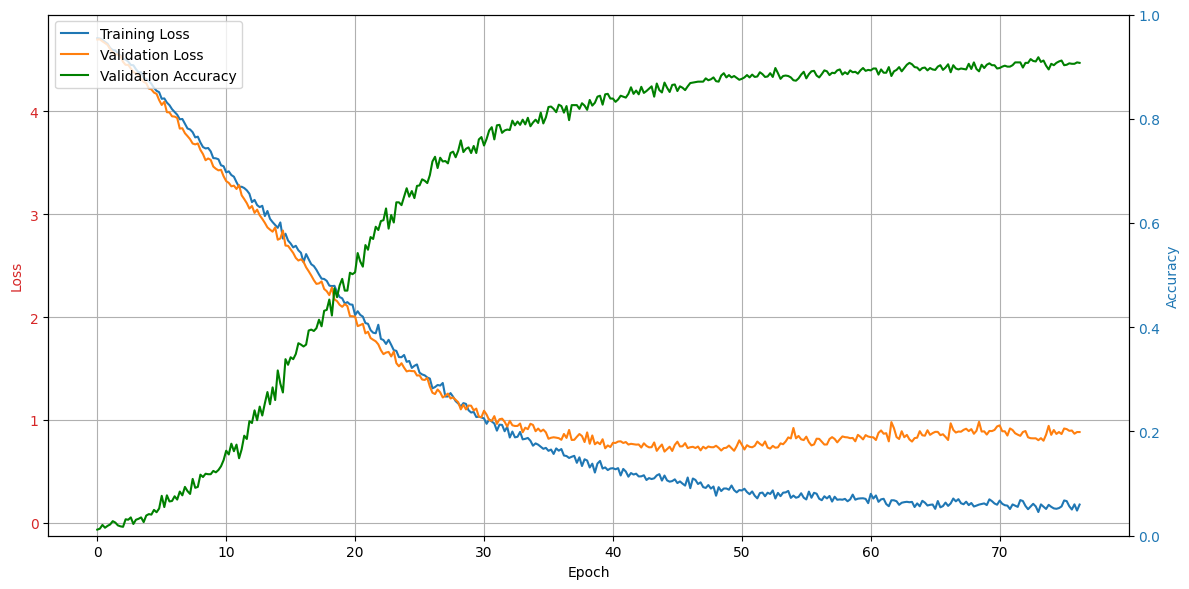

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = '/home/rag/experimental_trial/results/training_logs/training_log_100_epochs20240608_201039.csv'
data = pd.read_csv(file_path)

# Function to convert steps to epochs
def steps_to_epochs(df, interval=5):
    epochs = []
    current_epoch = 0
    for i in range(len(df)):
        if i % interval == 0 and i != 0:
            current_epoch += 1
        epochs.append(current_epoch)
    df['Epoch'] = epochs
    df['GraphicSteps'] = range(1, len(df) + 1)
    return df

# Convert steps to epochs for different metrics
training_loss = steps_to_epochs(data[['Step', 'Training Loss']].dropna())
validation_loss = steps_to_epochs(data[['Step', 'Validation Loss']].dropna())
accuracy = steps_to_epochs(data[['Step', 'Accuracy']].dropna())

# Function to plot both training/validation loss and accuracy on the same graph
def plot_combined(training_loss, validation_loss, accuracy):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plotting loss on the primary y-axis
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(training_loss['GraphicSteps'], training_loss['Training Loss'], label='Training Loss')
    ax1.plot(validation_loss['GraphicSteps'], validation_loss['Validation Loss'], label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)

    # Creating a second y-axis for accuracy
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(accuracy['GraphicSteps'], accuracy['Accuracy'], label='Validation Accuracy', color='green')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 1)  # Setting the limit for accuracy

    # Adding legends for both axes
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(handles1 + handles2, labels1 + labels2, loc='best')

    # Adjusting the x-axis to show epochs
    epoch_ticks = training_loss.groupby('Epoch').first()['GraphicSteps'].values
    epoch_labels = training_loss['Epoch'].unique()
    selected_ticks = epoch_ticks[::10]  # Adjust this as needed
    selected_labels = epoch_labels[::10]  # Adjust this as needed

    if 1 not in selected_ticks:
        selected_ticks = [1] + list(selected_ticks)
        selected_labels = [1] + list(selected_langs)

    ax1.set_xticks(selected_ticks, labels=selected_labels)

    plt.tight_layout()
    plt.show()

# Plotting the combined results
plot_combined(training_loss, validation_loss, accuracy)


# now we do the feature extraction for the finetuned model

In [11]:
import os
import numpy as np
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from tqdm import tqdm
import librosa

# Initialize the processor and model for wav2vec 2.0
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
finetuned_model_path = "/home/rag/experimental_trial/results/newest_model_9144acc"

model = Wav2Vec2Model.from_pretrained(finetuned_model_path, output_hidden_states=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

def check_directories_exist(directory, layer_indices):
    """Prüft, ob die benötigten Verzeichnisse für jede Schicht bereits existieren."""
    all_exist = True
    for index in layer_indices:
        layer_dir = os.path.join(directory, f"layer_{index}")
        if not os.path.exists(layer_dir):
            all_exist = False
            break
    return all_exist

def load_audio_files(directory, layer_indices=[-1]):
    """Lädt alle MP3-Dateien im angegebenen Verzeichnis und extrahiert die Repräsentationen aus den spezifizierten Schichten."""
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith(".mp3"):
            file_path = os.path.join(directory, filename)
            audio, sr = librosa.load(file_path, sr=16000)
            inputs = processor(audio, sampling_rate=sr, return_tensors="pt")
            input_values = inputs["input_values"].to(device)
            
            with torch.no_grad():
                outputs = model(input_values)
                for index in layer_indices:
                    hidden_states = outputs.hidden_states[index]
                    # creating sub directory for each layer in speaker directory
                    layer_dir = os.path.join(directory, f"layer_{index}")
                    os.makedirs(layer_dir, exist_ok=True)
                    save_path = os.path.join(layer_dir, f"{os.path.splitext(filename)[0]}_layer_{index}.npy")
                    np.save(save_path, hidden_states.cpu().numpy())

def process_audio_directory(base_directory, layer_indices=range(25)):
    """Verarbeitet Audio-Dateien in den angegebenen Verzeichnissen, falls die Ziellayer-Verzeichnisse noch nicht existieren."""
    for d in os.listdir(base_directory):
        dir_path = os.path.join(base_directory, d)
        if os.path.isdir(dir_path) and not check_directories_exist(dir_path, layer_indices):
            load_audio_files(dir_path, layer_indices)

directory_path = os.path.expanduser("/home/rag/experimental_trial/data/all_speakers_wav2vec_finetuned")

process_audio_directory(directory_path)


  0%|          | 0/50 [00:00<?, ?it/s]/home/rag/base_venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 50/50 [00:03<00:00, 12.68it/s]


# now we finetune a model but only the first 2 layers

In [ ]:
import os
import sys
import torch
import librosa
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
import math
from datasets import load_metric
from datetime import datetime

# Load the processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

# Define the custom dataset class using pandas
class LocalAudioDataset(Dataset):
    def __init__(self, csv_file, processor, subset, noise_factor=0.0):
        self.processor = processor
        self.data = pd.read_csv(csv_file)
        self.data = self.data[self.data['subset'] == subset]
        self.speaker_ids = {label: idx for idx, label in enumerate(self.data['label'].unique())}
        self.data['label'] = self.data['label'].map(self.speaker_ids)
        self.noise_factor = noise_factor
        
        print(f"Loaded {len(self.speaker_ids)} speakers: {self.speaker_ids}")
        print(f"Total files in {subset}: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = self.data.iloc[idx]['path']
        label = self.data.iloc[idx]['label']
        
        try:
            audio, sr = librosa.load(file_path, sr=16000)
            audio = librosa.to_mono(audio)
            audio = self._pad_or_truncate(audio, max_length=16000)
            if self.noise_factor > 0:
                audio = self._add_noise(audio)
            input_values = self.processor(audio, sampling_rate=16000, return_tensors="pt").input_values.squeeze(0)
            return {"input_values": input_values, "labels": label}
        except Exception as e:
            print(f"Error loading {file_path}: {e}", file=sys.stderr)
            return self.__getitem__((idx + 1) % len(self))

    def _pad_or_truncate(self, audio, max_length):
        if len(audio) < max_length:
            pad_size = max_length - len(audio)
            audio = np.pad(audio, (0, pad_size), 'constant', constant_values=(0, 0))
        else:
            audio = audio[:max_length]
        return audio

    def _add_noise(self, audio):
        noise = np.random.randn(len(audio))
        augmented_audio = audio + self.noise_factor * noise
        augmented_audio = augmented_audio.astype(type(audio[0]))
        return augmented_audio

# Paths to dataset CSV file
csv_file = 'dataset_large.csv'
train_dataset = LocalAudioDataset(csv_file, processor, 'train', noise_factor=0)
validate_dataset = LocalAudioDataset(csv_file, processor, 'validate')
test_dataset = LocalAudioDataset(csv_file, processor, 'test')

num_speakers = len(train_dataset.speaker_ids)
print(f"Number of unique speakers: {num_speakers}")

print(f"Labels in train dataset: {train_dataset.data['label'].tolist()}")
print(f"Labels in test dataset: {test_dataset.data['label'].tolist()}")

# Load the best model
# Initialize the model with the correct number of output classes
config = Wav2Vec2Config.from_pretrained("facebook/wav2vec2-large-960h", num_labels=num_speakers)
model = Wav2Vec2ForSequenceClassification(config)

# Modify the transformer layers to use only 2 layers
model.wav2vec2.encoder.config.num_hidden_layers = 2
model.wav2vec2.encoder.layers = model.wav2vec2.encoder.layers[:2]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

def validate_labels(dataset):
    for item in dataset:
        label = item['labels']
        if label >= num_speakers or label < 0:
            print(f"Invalid label {label} for item: {item}")
            raise ValueError(f"Invalid label {label} found in dataset.")
    print("All labels are valid.")

validate_labels(train_dataset)
validate_labels(validate_dataset)
validate_labels(test_dataset)

batch_size = 8
steps_per_epoch = math.ceil(len(train_dataset) / batch_size)
logging_steps = steps_per_epoch // 5
eval_steps = steps_per_epoch // 5

accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

log_dir = "/home/rag/experimental_trial/results/training_logs"
os.makedirs(log_dir, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_file = os.path.join(log_dir, f"training_log_versuch2_2layer{timestamp}.csv")
with open(log_file, "w") as f:
    f.write("Timestamp,Step,Training Loss,Validation Loss,Accuracy\n")

class SaveMetricsCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            with open(log_file, "a") as f:
                timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                step = state.global_step
                training_loss = logs.get("loss", "")
                validation_loss = logs.get("eval_loss", "")
                accuracy = logs.get("eval_accuracy", "")
                f.write(f"{timestamp},{step},{training_loss},{validation_loss},{accuracy}\n")

class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience=100, early_stopping_threshold=0.0):
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_threshold = early_stopping_threshold
        self.best_metric = None
        self.patience_counter = 0

    def on_evaluate(self, args, state, control, **kwargs):
        metric = kwargs.get("metrics", {}).get("eval_loss")
        if metric is None:
            return
        
        if self.best_metric is None or metric < self.best_metric - self.early_stopping_threshold:
            self.best_metric = metric
            self.patience_counter = 0
        else:
            self.patience_counter += 1
        
        if self.patience_counter >= self.early_stopping_patience:
            print(f"Early stopping at step {state.global_step}")
            control.should_training_stop = True

training_args = TrainingArguments(
    output_dir="./results",
    group_by_length=True,
    per_device_train_batch_size=batch_size,
    evaluation_strategy="steps",
    num_train_epochs=100,
    save_steps=logging_steps,
    eval_steps=eval_steps,
    logging_steps=logging_steps,
    learning_rate=5e-6,
    save_total_limit=2,
    no_cuda=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # lower eval_loss is better
    save_strategy="steps"  # or "epoch" if you prefer to save every epoch
)

# Extend the Trainer class
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.best_loss_model_dir = "./results/best_model_loss_2layer_versuch2"
        self.best_accuracy_model_dir = "./results/best_model_accuracy_versuch2"
        os.makedirs(self.best_loss_model_dir, exist_ok=True)
        os.makedirs(self.best_accuracy_model_dir, exist_ok=True)
        self.best_eval_loss = float("inf")
        self.best_eval_accuracy = 0.0

    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        eval_metrics = super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)
        
        current_eval_loss = eval_metrics["eval_loss"]
        current_eval_accuracy = eval_metrics["eval_accuracy"]
        
        if current_eval_loss < self.best_eval_loss:
            self.best_eval_loss = current_eval_loss
            self.save_model(self.best_loss_model_dir)
            print(f"Saved best model according to eval_loss: {self.best_eval_loss}")

        if current_eval_accuracy > self.best_eval_accuracy:
            self.best_eval_accuracy = current_eval_accuracy
            self.save_model(self.best_accuracy_model_dir)
            print(f"Saved best model according to eval_accuracy: {self.best_eval_accuracy}")

        return eval_metrics

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validate_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    callbacks=[SaveMetricsCallback(), EarlyStoppingCallback(early_stopping_patience=50)]
)

trainer.train()

metrics = trainer.evaluate(test_dataset)

print(f"Test set evaluation metrics: {metrics}")
print("Training and evaluation completed successfully!")

print(f"Best model according to eval_loss saved to {trainer.best_loss_model_dir}")
print(f"Best model according to eval_accuracy saved to {trainer.best_accuracy_model_dir}")

processor.save_pretrained(trainer.best_loss_model_dir)
processor.save_pretrained(trainer.best_accuracy_model_dir)

In [1]:
import os
import sys
import torch
import librosa
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
import math
from datasets import load_metric
from datetime import datetime


processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

# Define the custom dataset class using pandas
class LocalAudioDataset(Dataset):
    def __init__(self, csv_file, processor, subset, noise_factor=0.0):
        self.processor = processor
        self.data = pd.read_csv(csv_file)
        self.data = self.data[self.data['subset'] == subset]
        self.speaker_ids = {label: idx for idx, label in enumerate(self.data['label'].unique())}
        self.data['label'] = self.data['label'].map(self.speaker_ids)
        self.noise_factor = noise_factor
        
        print(f"Loaded {len(self.speaker_ids)} speakers: {self.speaker_ids}")
        print(f"Total files in {subset}: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = self.data.iloc[idx]['path']
        label = self.data.iloc[idx]['label']
        
        try:
            audio, sr = librosa.load(file_path, sr=16000)
            audio = librosa.to_mono(audio)
            audio = self._pad_or_truncate(audio, max_length=16000)
            if self.noise_factor > 0:
                audio = self._add_noise(audio)
            input_values = self.processor(audio, sampling_rate=16000, return_tensors="pt").input_values.squeeze(0)
            return {"input_values": input_values, "labels": label}
        except Exception as e:
            print(f"Error loading {file_path}: {e}", file=sys.stderr)
            return self.__getitem__((idx + 1) % len(self))

    def _pad_or_truncate(self, audio, max_length):
        if len(audio) < max_length:
            pad_size = max_length - len(audio)
            audio = np.pad(audio, (0, pad_size), 'constant', constant_values=(0, 0))
        else:
            audio = audio[:max_length]
        return audio

    def _add_noise(self, audio):
        noise = np.random.randn(len(audio))
        augmented_audio = audio + self.noise_factor * noise
        augmented_audio = augmented_audio.astype(type(audio[0]))
        return augmented_audio

# Paths to dataset CSV file
csv_file = 'dataset_large.csv'
train_dataset = LocalAudioDataset(csv_file, processor, 'train', noise_factor=0.005)
validate_dataset = LocalAudioDataset(csv_file, processor, 'validate')
test_dataset = LocalAudioDataset(csv_file, processor, 'test')

num_speakers = len(train_dataset.speaker_ids)
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-large-960h",  num_labels=num_speakers)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

def validate_labels(dataset):
    for item in dataset:
        label = item['labels']
        if label >= num_speakers or label < 0:
            print(f"Invalid label {label} for item: {item}")
            raise ValueError(f"Invalid label {label} found in dataset.")
    print("All labels are valid.")

validate_labels(train_dataset)
validate_labels(validate_dataset)
validate_labels(test_dataset)

batch_size = 8
steps_per_epoch = math.ceil(len(train_dataset) / batch_size)
logging_steps = steps_per_epoch // 5
eval_steps = steps_per_epoch // 5

accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

log_dir = "/home/rag/experimental_trial/results/training_logs"
os.makedirs(log_dir, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_file = os.path.join(log_dir, f"training_log_100_epochs{timestamp}.csv")
with open(log_file, "w") as f:
    f.write("Timestamp,Step,Training Loss,Validation Loss,Accuracy\n")

class SaveMetricsCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            with open(log_file, "a") as f:
                timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                step = state.global_step
                training_loss = logs.get("loss", "")
                validation_loss = logs.get("eval_loss", "")
                accuracy = logs.get("eval_accuracy", "")
                f.write(f"{timestamp},{step},{training_loss},{validation_loss},{accuracy}\n")

class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience=100, early_stopping_threshold=0.0):
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_threshold = early_stopping_threshold
        self.best_metric = None
        self.patience_counter = 0

    def on_evaluate(self, args, state, control, **kwargs):
        metric = kwargs.get("metrics", {}).get("eval_loss")
        if metric is None:
            return
        
        if self.best_metric is None or metric < self.best_metric - self.early_stopping_threshold:
            self.best_metric = metric
            self.patience_counter = 0
        else:
            self.patience_counter += 1
        
        if self.patience_counter >= self.early_stopping_patience:
            print(f"Early stopping at step {state.global_step}")
            control.should_training_stop = True

training_args = TrainingArguments(
    output_dir="./results",
    group_by_length=True,
    per_device_train_batch_size=batch_size,
    evaluation_strategy="steps",
    num_train_epochs=100,
    save_steps=logging_steps,
    eval_steps=eval_steps,
    logging_steps=logging_steps,
    learning_rate=5e-6,
    save_total_limit=2,
    no_cuda=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # lower eval_loss is better
    save_strategy="steps"  # or "epoch" if you prefer to save every epoch
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validate_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    callbacks=[SaveMetricsCallback()]  # Entfernte EarlyStoppingCallback
)

trainer.train()

metrics = trainer.evaluate(test_dataset)

print(f"Test set evaluation metrics: {metrics}")
print("Training and evaluation completed successfully!")

best_model_dir = "./results/best_model_90_epochs_version5_noise"
os.makedirs(best_model_dir, exist_ok=True)

trainer.save_model(best_model_dir)
processor.save_pretrained(best_model_dir)

print(f"Best model saved to {best_model_dir}")


KeyboardInterrupt: 

# now we try to optimize the number of layers using optuna 

In [ ]:
import optuna
import torch
from torch.utils.data import Dataset
from transformers import Wav2Vec2Processor, Trainer, TrainingArguments, TrainerCallback, Wav2Vec2Config, Wav2Vec2Model
import pandas as pd
import librosa
import numpy as np
import os
import sys
import math
from datasets import load_metric
from datetime import datetime

# Load the processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

# Define the custom dataset class
class LocalAudioDataset(Dataset):
    def __init__(self, csv_file, processor, subset, noise_factor=0.0):
        self.processor = processor
        self.data = pd.read_csv(csv_file)
        self.data = self.data[self.data['subset'] == subset]
        self.speaker_ids = {label: idx for idx, label in enumerate(self.data['label'].unique())}
        self.data['label'] = self.data['label'].map(self.speaker_ids)
        self.noise_factor = noise_factor
        
        print(f"Loaded {len(self.speaker_ids)} speakers: {self.speaker_ids}")
        print(f"Total files in {subset}: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = self.data.iloc[idx]['path']
        label = self.data.iloc[idx]['label']
        
        try:
            audio, sr = librosa.load(file_path, sr=16000)
            audio = librosa.to_mono(audio)
            audio = self._pad_or_truncate(audio, max_length=16000)
            if self.noise_factor > 0:
                audio = self._add_noise(audio)
            input_values = self.processor(audio, sampling_rate=16000, return_tensors="pt").input_values.squeeze(0)
            return {"input_values": input_values, "labels": label}
        except Exception as e:
            print(f"Error loading {file_path}: {e}", file=sys.stderr)
            return self.__getitem__((idx + 1) % len(self))

    def _pad_or_truncate(self, audio, max_length):
        if len(audio) < max_length:
            pad_size = max_length - len(audio)
            audio = np.pad(audio, (0, pad_size), 'constant', constant_values=(0, 0))
        else:
            audio = audio[:max_length]
        return audio

    def _add_noise(self, audio):
        noise = np.random.randn(len(audio))
        augmented_audio = audio + self.noise_factor * noise
        augmented_audio = augmented_audio.astype(type(audio[0]))
        return augmented_audio

# Paths to dataset CSV file
csv_file = 'dataset_large.csv'
train_dataset = LocalAudioDataset(csv_file, processor, 'train', noise_factor=0)
validate_dataset = LocalAudioDataset(csv_file, processor, 'validate')
test_dataset = LocalAudioDataset(csv_file, processor, 'test')

num_speakers = len(train_dataset.speaker_ids)
print(f"Number of unique speakers: {num_speakers}")

print(f"Labels in train dataset: {train_dataset.data['label'].tolist()}")
print(f"Labels in test dataset: {test_dataset.data['label'].tolist()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def validate_labels(dataset):
    for item in dataset:
        label = item['labels']
        if label >= num_speakers or label < 0:
            print(f"Invalid label {label} for item: {item}")
            raise ValueError(f"Invalid label {label} found in dataset.")
    print("All labels are valid.")

validate_labels(train_dataset)
validate_labels(validate_dataset)
validate_labels(test_dataset)

batch_size = 8
steps_per_epoch = math.ceil(len(train_dataset) / batch_size)
logging_steps = steps_per_epoch // 5
eval_steps = steps_per_epoch // 5

accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

log_dir = "/home/rag/experimental_trial/results/training_logs"
os.makedirs(log_dir, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_file = os.path.join(log_dir, f"training_log_versuch2_2layer{timestamp}.csv")
with open(log_file, "w") as f:
    f.write("Timestamp,Step,Training Loss,Validation Loss,Accuracy\n")

class SaveMetricsCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            with open(log_file, "a") as f:
                timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                step = state.global_step
                training_loss = logs.get("loss", "")
                validation_loss = logs.get("eval_loss", "")
                accuracy = logs.get("eval_accuracy", "")
                f.write(f"{timestamp},{step},{training_loss},{validation_loss},{accuracy}\n")

class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience=100, early_stopping_threshold=0.0):
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_threshold = early_stopping_threshold
        self.best_metric = None
        self.patience_counter = 0

    def on_evaluate(self, args, state, control, **kwargs):
        metric = kwargs.get("metrics", {}).get("eval_loss")
        if metric is None:
            return
        
        if self.best_metric is None or metric < self.best_metric - self.early_stopping_threshold:
            self.best_metric = metric
            self.patience_counter = 0
        else:
            self.patience_counter += 1
        
        if self.patience_counter >= self.early_stopping_patience:
            print(f"Early stopping at step {state.global_step}")
            control.should_training_stop = True

# Custom classification head with mean pooling
class CustomWav2Vec2ForSequenceClassification(Wav2Vec2ForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.pooling = torch.nn.AdaptiveAvgPool1d(1)
    
    def forward(self, input_values, attention_mask=None, labels=None):
        outputs = self.wav2vec2(input_values, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        pooled_output = self.pooling(hidden_states.transpose(1, 2)).squeeze(-1)
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            loss = self.compute_loss(logits, labels)
        
        return (loss, logits) if loss is not None else (logits,)

# Extend the Trainer class
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.best_loss_model_dir = "./results/best_model_loss_2layer_versuch2"
        self.best_accuracy_model_dir = "./results/best_model_accuracy_versuch2"
        os.makedirs(self.best_loss_model_dir, exist_ok=True)
        os.makedirs(self.best_accuracy_model_dir, exist_ok=True)
        self.best_eval_loss = float("inf")
        self.best_eval_accuracy = 0.0

    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        eval_metrics = super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)
        
        current_eval_loss = eval_metrics["eval_loss"]
        current_eval_accuracy = eval_metrics["eval_accuracy"]
        
        if current_eval_loss < self.best_eval_loss:
            self.best_eval_loss = current_eval_loss
            self.save_model(self.best_loss_model_dir)
            print(f"Saved best model according to eval_loss: {self.best_eval_loss}")

        if current_eval_accuracy > self.best_eval_accuracy:
            self.best_eval_accuracy = current_eval_accuracy
            self.save_model(self.best_accuracy_model_dir)
            print(f"Saved best model according to eval_accuracy: {self.best_eval_accuracy}")

        return eval_metrics

def objective(trial):
    # Suggest the number of layers
    num_layers = trial.suggest_int('num_layers', 1, 24)
    
    # Suggest the learning rate within a narrow range around 5e-6
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-5)

    # Load the model configuration with the suggested number of layers
    config = Wav2Vec2Config.from_pretrained("facebook/wav2vec2-large-960h", num_labels=num_speakers)
    config.num_hidden_layers = num_layers
    model = CustomWav2Vec2ForSequenceClassification(config)
    
    # Ensure the correct number of layers are set
    model.wav2vec2.encoder.layers = model.wav2vec2.encoder.layers[:num_layers]
    
    # Transfer the model to the correct device
    model = model.to(device)
    
    training_args = TrainingArguments(
        output_dir="./results",
        group_by_length=True,
        per_device_train_batch_size=batch_size,
        evaluation_strategy="steps",
        num_train_epochs=100,
        save_steps=logging_steps,
        eval_steps=eval_steps,
        logging_steps=logging_steps,
        learning_rate=learning_rate,
        save_total_limit=2,
        no_cuda=False,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,  # lower eval_loss is better
        save_strategy="steps"  # or "epoch" if you prefer to save every epoch
    )
    
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=validate_dataset,
        tokenizer=processor,
        compute_metrics=compute_metrics,
        callbacks=[SaveMetricsCallback(), EarlyStoppingCallback(early_stopping_patience=50)]
    )
    
    trainer.train()
    
    # Evaluate the model
    metrics = trainer.evaluate(validate_dataset)
    return metrics['eval_loss']

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")




In [2]:



training_args = TrainingArguments(
    output_dir="./results",
    group_by_length=True,
    per_device_train_batch_size=batch_size,
    evaluation_strategy="steps",
    num_train_epochs=100,
    save_steps=logging_steps,
    eval_steps=eval_steps,
    logging_steps=logging_steps,
    learning_rate=best_learning_rate,
    save_total_limit=2,
    no_cuda=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # lower eval_loss is better
    save_strategy="steps"  # or "epoch" if you prefer to save every epoch
)


trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validate_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    callbacks=[SaveMetricsCallback(), EarlyStoppingCallback(early_stopping_patience=50)]
)

trainer.train()
metrics = trainer.evaluate(test_dataset)

print(f"Test set evaluation metrics: {metrics}")
print("Training and evaluation completed successfully!")

print(f"Best model according to eval_loss saved to {trainer.best_loss_model_dir}")
print(f"Best model according to eval_accuracy saved to {trainer.best_accuracy_model_dir}")

processor.save_pretrained(trainer.best_loss_model_dir)
processor.save_pretrained(trainer.best_accuracy_model_dir)
# Using the best number of layers and learning rate for final training and evaluation
best_num_layers = trial.params['num_layers']
best_learning_rate = trial.params['learning_rate']

config = Wav2Vec2Config.from_pretrained("facebook/wav2vec2-large-960h", num_labels=num_speakers)
config.num_hidden_layers = best_num_layers
model = CustomWav2Vec2ForSequenceClassification(config)
model.wav2vec2.encoder.layers = model.wav2vec2.encoder.layers[:best_num_layers]
model = model.to(device)

NameError: name 'trial' is not defined